In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

import sys
# sys.path.append('../')
os.chdir("/home/yxchen/Real-time-GesRec")

In [7]:
import argparse
import time
import os
import sys
import json
import shutil
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import torch
from torch.autograd import Variable
from sklearn.metrics import confusion_matrix
from torch.nn import functional as F

from opts import parse_opts_offline
from model import generate_model
from mean import get_mean, get_std
from spatial_transforms import *
from temporal_transforms import *
from target_transforms import ClassLabel, VideoID
from target_transforms import Compose as TargetCompose
from dataset import get_training_set, get_validation_set, get_test_set, get_online_data
from utils import Logger
from train import train_epoch
from validation import val_epoch
import test
from utils import AverageMeter, calculate_precision, calculate_recall
import pdb
from sklearn.metrics import confusion_matrix

opt = parse_opts_offline(
['--root_path', '/home/yxchen/Real-time-GesRec', 
 '--video_path', '/mnt/data/yxchen/gesture-datasets/ems', 
 '--annotation_path', 'annotation_ems/ems07.1.json', 
 '--result_path', 'results/ems07.1_test', 
 '--resume_path', '/home/yxchen/Real-time-GesRec/results/ems07/save_100.pth', 
 '--dataset', 'ems', 
 '--sample_duration', '32', 
 '--model', 'resnext',
 '--model_depth', '101',
 '--resnet_shortcut', 'B',
 '--batch_size', '1',
 '--n_finetune_classes', '10',
 '--n_threads', '1',
 '--checkpoint', '1',
 '--modality', 'RGB',
 '--n_val_samples', '1',
 '--test_subset', 'test']
)
if opt.root_path != '':
    opt.video_path = os.path.join(opt.root_path, opt.video_path)
    opt.annotation_path = os.path.join(opt.root_path, opt.annotation_path)
    opt.result_path = os.path.join(opt.root_path, opt.result_path)
    if opt.resume_path:
        opt.resume_path = os.path.join(opt.root_path, opt.resume_path)
    if opt.pretrain_path:
        opt.pretrain_path = os.path.join(opt.root_path, opt.pretrain_path)
opt.scales = [opt.initial_scale]
for i in range(1, opt.n_scales):
    opt.scales.append(opt.scales[-1] * opt.scale_step)
opt.arch = '{}-{}'.format(opt.model, opt.model_depth)
opt.mean = get_mean(opt.norm_value)
opt.std = get_std(opt.norm_value)

print(opt)



Namespace(annotation_path='/home/yxchen/Real-time-GesRec/annotation_ems/ems07.1.json', arch='resnext-101', batch_size=1, begin_epoch=1, checkpoint=1, crop_position_in_test='c', dampening=0.9, dataset='ems', ft_begin_index=0, initial_scale=1.0, learning_rate=0.1, lr_patience=10, lr_steps=[10, 25, 50, 80, 100], manual_seed=1, mean=[114.7748, 107.7354, 99.475], mean_dataset='activitynet', modality='RGB', model='resnext', model_depth=101, momentum=0.9, n_classes=400, n_epochs=200, n_finetune_classes=10, n_scales=5, n_threads=1, n_val_samples=1, nesterov=False, no_cuda=False, no_hflip=False, no_mean_norm=False, no_softmax_in_test=False, no_train=False, no_val=False, norm_value=1, optimizer='sgd', pretrain_path='', resnet_shortcut='B', resnext_cardinality=32, result_path='/home/yxchen/Real-time-GesRec/results/ems07.1_test', resume_path='/home/yxchen/Real-time-GesRec/results/ems07/save_100.pth', root_path='/home/yxchen/Real-time-GesRec', sample_duration=32, sample_size=112, scale_in_test=1.0,

In [ ]:
import warnings
warnings.filterwarnings('ignore')

def calculate_accuracy(outputs, targets, topk=(1,)):
    maxk = max(topk)
    batch_size = targets.size(0)
    _, pred = outputs.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(targets.view(1, -1).expand_as(pred))
    ret = []
    for k in topk:
        correct_k = correct[:k].float().sum().item()
        ret.append(correct_k / batch_size)

    return ret

if not os.path.exists(opt.result_path):
    os.makedirs(opt.result_path)

with open(os.path.join(opt.result_path, 'opts.json'), 'w') as opt_file:
    json.dump(vars(opt), opt_file)

torch.manual_seed(opt.manual_seed)

model, parameters = generate_model(opt)
# print(model)
pytorch_total_params = sum(p.numel() for p in model.parameters() if
                           p.requires_grad)
print("Total number of trainable parameters: ", pytorch_total_params)

if opt.no_mean_norm and not opt.std_norm:
    norm_method = Normalize([0, 0, 0], [1, 1, 1])
elif not opt.std_norm:
    norm_method = Normalize(opt.mean, [1, 1, 1])
else:
    norm_method = Normalize(opt.mean, opt.std)

# original
spatial_transform = Compose([
    #Scale(opt.sample_size),
    Scale(112),
    CenterCrop(112),
    ToTensor(opt.norm_value), norm_method
    ])

temporal_transform = TemporalCenterCrop(opt.sample_duration)

target_transform = ClassLabel()
test_data = get_test_set(
    opt, spatial_transform, temporal_transform, target_transform)

test_loader = torch.utils.data.DataLoader(
            test_data,
            batch_size=opt.batch_size,
            shuffle=False,
            num_workers=opt.n_threads,
            pin_memory=True)
test_logger = Logger(os.path.join(opt.result_path, 'test.log'),
 [ 'top1', 'top5', 'precision', 'recall'])


if opt.resume_path:
    print('loading checkpoint {}'.format(opt.resume_path))
    checkpoint = torch.load(opt.resume_path)
    assert opt.arch == checkpoint['arch']

    opt.begin_epoch = checkpoint['epoch']
    model.load_state_dict(checkpoint['state_dict'])


#test.test(test_loader, model, opt, test_data.class_names)

recorder = []

print('run')

model.eval()

batch_time = AverageMeter()
top1 = AverageMeter()
top5 = AverageMeter()
precisions = AverageMeter() #
recalls = AverageMeter()

y_true = []
y_pred = []
end_time = time.time()

# fout = open(os.path.join(opt.result_path, 'result.csv'), 'w')

for i, (inputs, targets) in enumerate(test_loader):
    if not opt.no_cuda:
        targets = targets.cuda(non_blocking=True)
    #inputs = Variable(torch.squeeze(inputs), volatile=True)
    with torch.no_grad():
        inputs = Variable(inputs)
        targets = Variable(targets)
        outputs = model(inputs)
        if not opt.no_softmax_in_test:
            outputs = F.softmax(outputs, dim=1)
        recorder.append(outputs.data.cpu().numpy().copy())
    y_true.extend(targets.cpu().numpy().tolist())
    y_pred.extend(outputs.argmax(1).cpu().numpy().tolist())

    _cls = outputs.argmax(1).cpu().numpy().tolist()[0]

    if outputs.size(1) <= 4:

        prec1= calculate_accuracy(outputs, targets, topk=(1,))
        precision = calculate_precision(outputs, targets) #
        recall = calculate_recall(outputs,targets)


        top1.update(prec1[0], inputs.size(0))
        precisions.update(precision, inputs.size(0))
        recalls.update(recall,inputs.size(0))

        batch_time.update(time.time() - end_time)
        end_time = time.time()

#         print('[{0}/{1}]\t'
#               'Time {batch_time.val:.5f} ({batch_time.avg:.5f})\t'
#               'prec@1 {top1.avg:.5f} \t'
#               'precision {precision.val:.5f} ({precision.avg:.5f})\t'
#               'recall {recall.val:.5f} ({recall.avg:.5f})'.format(
#                   i + 1,
#                   len(test_loader),
#                   batch_time=batch_time,
#                   top1 =top1,
#                   precision = precisions,
#                   recall = recalls))
    else:

        prec1, prec5 = calculate_accuracy(outputs, targets, topk=(1,5))
        precision = calculate_precision(outputs, targets) #
        recall = calculate_recall(outputs,targets)


        top1.update(prec1, inputs.size(0))
        top5.update(prec5, inputs.size(0))
        precisions.update(precision, inputs.size(0))
        recalls.update(recall,inputs.size(0))

        batch_time.update(time.time() - end_time)
        end_time = time.time()
#         print('[{0}/{1}]\t'
#               'Time {batch_time.val:.5f} ({batch_time.avg:.5f})\t'
#               'prec@1 {top1.avg:.5f} prec@5 {top5.avg:.5f}\t'
#               'precision {precision.val:.5f} ({precision.avg:.5f})\t'
#               'recall {recall.val:.5f} ({recall.avg:.5f})'.format(
#                   i + 1,
#                   len(test_loader),
#                   batch_time=batch_time,
#                   top1 =top1,
#                   top5=top5,
#                   precision = precisions,
#                   recall = recalls))
test_logger.log({
        'top1': top1.avg,
        'top5': top5.avg,
        'precision':precisions.avg,
        'recall':recalls.avg
    })

print('-----Evaluation is finished------')
print('Overall Prec@1 {:.05f}% Prec@5 {:.05f}%'.format(top1.avg, top5.avg))

cf = confusion_matrix(y_true, y_pred).astype(float)

cls_cnt = cf.sum(axis=1)
cls_hit = np.diag(cf)
cls_acc = cls_hit / cls_cnt
#print('Class Accuracy {:.02f}%'.format(cls_acc * 100))


0 arm_down_right : 94.12%
1 arm_down_left : 11.76%
2 wrist_right : 78.85%
3 wrist_down : 15.38%
4 wrist_left : 13.46%
5 down_left : 86.54%
6 arm_down : 55.77%
7 up_right : 46.15%
8 wrist_up : 36.54%
9 up_left : 98.08%
Normalized confusion matrix
Confusion matrix plotted


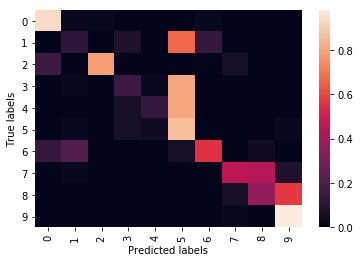

In [14]:
def plot_cm(cm, classes=None, normalize = True):
    import seaborn as sns
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    ax= plt.subplot()
    sns.heatmap(cm, annot=False, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
    plt.xticks(rotation='vertical')
    plt.yticks(rotation='horizontal')

    print("Confusion matrix plotted")

for i in range(len(test_data.class_names)):
    print(i, test_data.class_names[i], ': {:.02f}%'.format(cls_acc[i]*100))
plot_cm(cf)

# print("y_true, y_pred")
# for i in range(len(y_true)):
#     print(y_true[i], y_pred[i])